# данный код был переписан с семенарского занятия - тут я разбираюсь в том, как он работает

In [1]:
# !pip install nltk

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette= 'summer')

In [2]:
torch.full((5, ), 9)

tensor([9, 9, 9, 9, 9])

In [3]:
torch.empty((5))

tensor([-9.4239e-02,  1.6185e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00])

In [4]:
a = torch.tensor([1, 2, 3, 4, 5])

In [5]:
len(a)

5

In [6]:
a.shape[0]

5

In [7]:
[1, 2, 3, 4, 5][-0:]

[1, 2, 3, 4, 5]

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
f = open('../dataset/clean/original_cleaned.txt', encoding='utf-8')
dataset = f.read().replace('\n', '').replace('-', ' ').lower()
print(dataset[:200])

птичка в чужбине свято наблюдаю родной обычай старины: на волю птичку выпускаю при светлом празднике весны. я стал доступен утешенью; за что на бога мне роптать, когда хоть одному творенью я мог свобо


In [34]:
sentences = [i for i in sent_tokenize(dataset, language='russian') if len(i) > 20]

print(len(sentences))

71568


In [35]:
print(*sentences[:10], sep='\n---------\n')

птичка в чужбине свято наблюдаю родной обычай старины: на волю птичку выпускаю при светлом празднике весны.
---------
я стал доступен утешенью; за что на бога мне роптать, когда хоть одному творенью я мог свободу даровать!
---------
царское село хранитель милых чувств и прошлых наслаждений, о ты, певцу дубрав давно знакомый гений, воспоминание, рисуй передо мной волшебные места, где я живу душой, леса, где я любил, где чувство развивалось, где с первой юностью младенчество сливалось и где, взлелеянный природой и мечтой, я знал поэзию, веселость и покой.
---------
веди, веди меня под липовые сени, всегда любезные моей свободной лени, на берег озера, на тихий скат холмов!.
---------
да вновь увижу я ковры густых лугов, и дряхлый пук дерев, и светлую долину, и злачных берегов знакомую картину, и в тихом озере, средь блещущих зыбей, станицу гордую спокойных лебедей.
---------
* * * кто, волны, вас остановил, кто оковал ваш бег могучий, кто в пруд безмолвный и дремучий поток мятежный обрати

In [36]:
len(sentences)

71568

In [37]:
chars = Counter()
for sentence in tqdm(sentences):
  for char in sentence:
    chars[char] += 1

  0%|          | 0/71568 [00:00<?, ?it/s]

In [38]:
len(chars.items())

110

In [39]:
# print(*sorted(chars.items(), key=lambda x: -x[1]), sep='\n')

In [40]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 8921

for char, cnt, in tqdm(chars.items()):
  if cnt > counter_threshold:
    vocab.add(char)

  0%|          | 0/110 [00:00<?, ?it/s]

In [41]:
len(vocab)

44

In [42]:
char2ind = {char: i for i, char in enumerate(vocab)}
ind2char = {i: char for char, i in char2ind.items()}

In [43]:
class CharDataset:
  def __init__(self, sentences):
    self.data = sentences
    self.unk_id = char2ind['<unk>']
    self.bos_id = char2ind['<bos>']
    self.eos_id = char2ind['<eos>']
    self.pad_id = char2ind['<pad>']

  def __getitem__(self, idx: int) -> List[int]:
    tokenized_sentence = [self.bos_id]
    tokenized_sentence += [char2ind.get(char, self.unk_id) for char in self.data[idx]]
    tokenized_sentence += [self.eos_id]
    return tokenized_sentence

  def __len__(self) -> int:
    return len(self.data)


In [44]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=char2ind['<pad>']) -> torch.Tensor:
    max_seq_len = max(len(sent) for sent in input_batch)
    new_batch = []
    for sequence in input_batch:
      for _ in range(max_seq_len - len(sequence)):
        sequence.append(pad_id)
      new_batch.append(sequence)
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:, :-1],
        'target_ids': sequences[:, 1:]
    }
    return new_batch

In [45]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = CharDataset(train_sentences)
eval_dataset = CharDataset(eval_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=128)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=128)


In [46]:

class CharLM(nn.Module):
  def __init__(self, hidden_dim: int, vocab_size: int):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, hidden_dim)
    self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
    self.Linear1 = nn.Linear(hidden_dim, hidden_dim)
    self.Linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.Linear3 = nn.Linear(hidden_dim, hidden_dim)
    self.projection = nn.Linear(hidden_dim, vocab_size)

    self.non_lin = nn.Tanh()
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, input_batch) -> torch.Tensor:
    embeddings = self.embedding(input_batch)
    output, _ = self.rnn(embeddings)
    output = self.non_lin(output)

    x = self.non_lin(self.Linear1(output))
    x = self.non_lin(self.Linear2(x))
    x = self.non_lin(self.Linear3(x))

    projection = self.projection(self.non_lin(x))

    return projection


In [47]:
def evaluate(model, criterion) -> float:
  model.eval()
  perplexity = []
  with torch.no_grad():
    for batch in eval_dataloader:
      logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
      loss = criterion(
          logits,
          batch['target_ids'].flatten()
      )
      perplexity.append(torch.exp(loss).item())

  perplexity = sum(perplexity) / len(perplexity)
  return perplexity

In [48]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [49]:
num_epoch = 5
losses = []
perplexities = []

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses))
    perplexities.append(evaluate(model, criterion))

Training epoch 0::   0%|          | 0/448 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/448 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/448 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/448 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/448 [00:00<?, ?it/s]

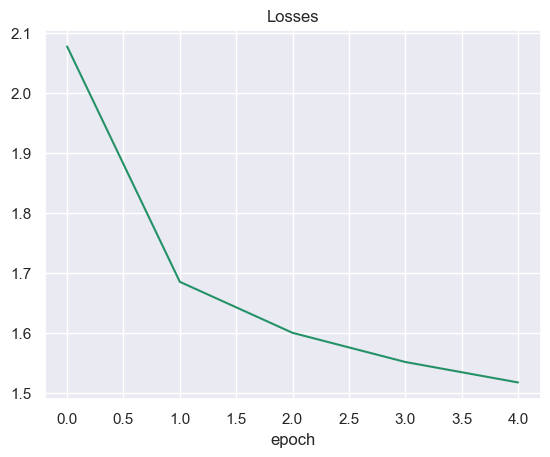

In [50]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel('epoch')
plt.show()



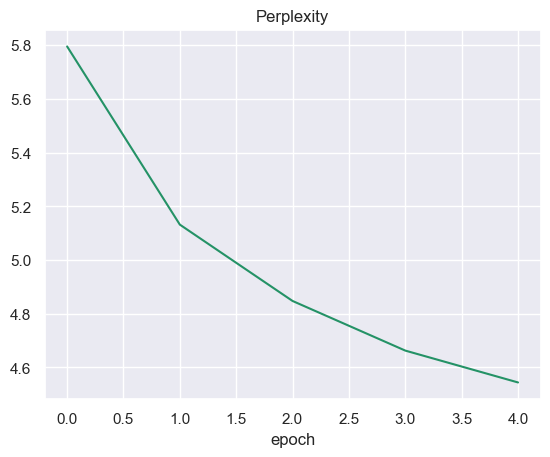

In [51]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [52]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:

    device = 'cpu'
    model = model.to(device)
    input_ids = [char2ind['<bos>']] + [
        char2ind.get(char, char2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):

            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])
            if next_char.item() == char2ind['<eos>']:
              break

    words = ''.join([ind2char[idx.item()] for idx in input_ids])

    return words

In [53]:
generate_sequence(model, starting_seq='швабрин прогуливался по ', max_seq_len=128)

'<bos>швабрин прогуливался по своем полу не подошел в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в св'

In [54]:
def generate_big(model, starting_seq: str, max_seq_len: int = 256, vel=3):
  res = ''
  for i in range(vel):
    res += generate_sequence(model, starting_seq=res, max_seq_len=max_seq_len)
    print(res)
  return res


In [55]:
generate_big(model, starting_seq='о, какой замечательный')

<bos>он подал ему под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в сво
<bos>он подал ему под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в сво<bos><unk><unk><unk>s<unk>он подал ему под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получ

'<bos>он подал ему под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в сво<bos><unk><unk><unk>s<unk>он подал ему под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в свое<bos><unk><unk><unk>s<unk>он подал ему под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полуденной стороны и получала в своем собрании под полу